#Hands on semantic segmentation. Computational Vision. 04/05/2022

In [57]:
import tensorflow.keras
import numpy as np
import os
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
import cv2
import matplotlib.pyplot as plt

Fist, we download the dataset  Oxford-IIIT pet dataset.

In [58]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  21.1M      0  0:00:35  0:00:35 --:--:-- 22.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  8514k      0  0:00:02  0:00:02 --:--:-- 8514k


Now we actually load our images using the following code:

In [59]:

input_dir = "images/" 
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


Let us visualize our dataset 

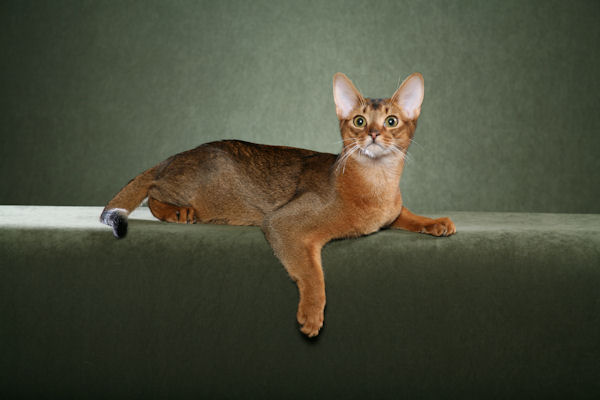

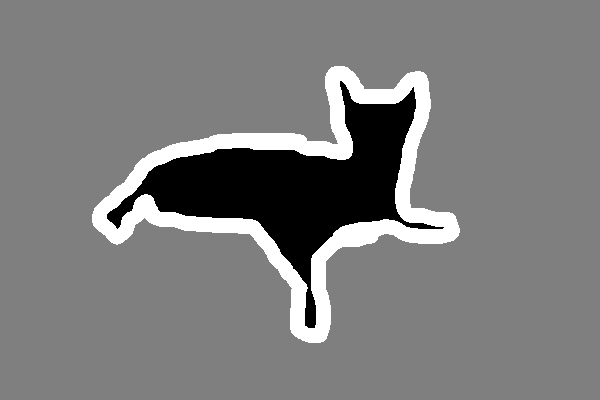

[0 1 2]


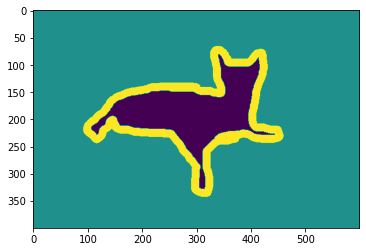

In [60]:


# Display input image #7
display(Image(filename=input_img_paths[0]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[0]))
display(img)
a = cv2.imread(target_img_paths[0])-1
print(np.unique(a))

plt.imshow(a[:,:,0])

We will now read our images, and build two different sets of data:
1. Training set;
2. Testing set.

The training set will be further divided into training and validation, with a hold-out approach. 

In [61]:
from tensorflow import keras
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
x = np.zeros((600,128,128,3), dtype="float32")
y = np.zeros((600,128,128,3), dtype="int32")

for j in range(0,600):
  img = cv2.imread(input_img_paths[j])
  img2 = cv2.imread(target_img_paths[j])
  try:
    img = cv2.resize(img,(128,128))
    img2=cv2.resize(img2,(128,128))
    x[j] = img
    y[j] = img2
  except:
    print('a')

x_test = np.zeros((50,128,128,3), dtype="float32")
y_test = np.zeros((50,128,128,3), dtype="int32")

for j in range(600,650):
  img = cv2.imread(input_img_paths[j])
  img2 = cv2.imread(target_img_paths[j])
  try:
    img = cv2.resize(img,(128,128))
    img2=cv2.resize(img2,(128,128))
    x_test[j-600] = img
    y_test[j-600] = img2
  except:
    print('a')

y = y[:,:,:,0]-1
y = tf.keras.utils.to_categorical(y,3)
y_test = y_test[:,:,:,0]-1
y_test = tf.keras.utils.to_categorical(y_test,3)

a


**Exercise 1**

Write the code to implement (from scratch) a Unet architecture, and evaluate it on the Oxford-IIIT pet dataset.

*   First, build a function conv_block(x, n_filters) that builds two convolutional layers, with n_filters. 
* Let's use a filter size 3x3



In [62]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x



*   Now, we define a function down_sample_block(x) that performs one step of our Unet:
1. Two convolutional layers (use function built in previous point)
2. Max pooling;



In [63]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

It is now the moment of upsample blocks.


*   Write a function upsample_block(x,features,filters), where features is the input you want to merge as in the Unet architecture.
*   Let's use kernel size of 3, and stride of 2 (we want to double the size of our features) in this block
* use layers.concatenate to merge features and the current map 



In [64]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

Now we build the Unet, following the original architecture

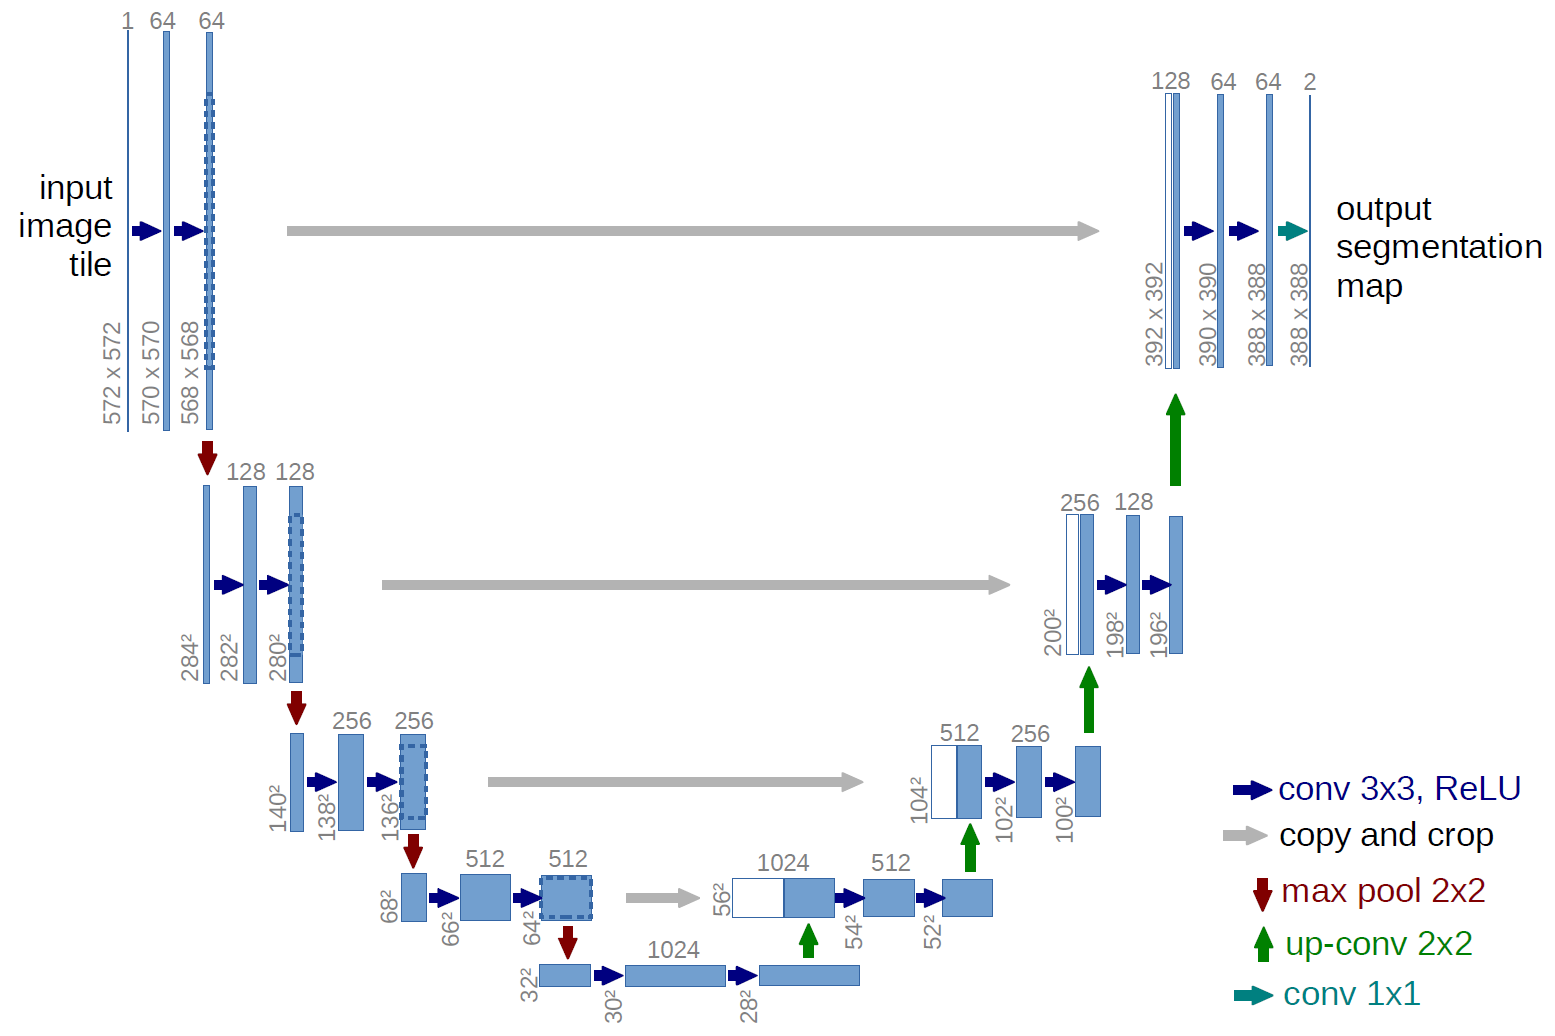

In [65]:
import tensorflow.keras.layers as layers 
def Unet():
   # inputs
   inputs = layers.Input(shape=(128,128,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(3, 1,  activation = "softmax")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

Now we compile the model with segmentation_models categorical cross entropy, adam optimizer and accuracy as metrics. 

In [70]:
unet_model = Unet()
!pip install segmentation_models
import segmentation_models as sm
unet_model.compile(optimizer=tf.keras.optimizers. Adam(),
                  loss=sm.losses.categorical_crossentropy,
                  metrics='accuracy')

Finally, we train our model 

In [71]:
import tensorflow.keras as keras
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

from sklearn.model_selection import train_test_split 
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size= 0.3,random_state = 1)
x_train = x_train /255.0
x_val = x_val / 255.0
# Train the model, doing validation at the end of each epoch.
epochs = 30

model_history = unet_model.fit(x_train,y_train,
                              epochs=epochs,
                              batch_size = 20,
                              validation_data=(x_val,y_val),shuffle=True)
#code here for fitting our data. Remember to use train_gen for training data, and val_gen for validation data 
_, train_acc = unet_model.evaluate(x_train, y_train, verbose=1)
_, test_acc =unet_model.evaluate(x_test, y_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Epoch 1/30
21/21 [==============================] - 48s 390ms/step - loss: 0.3265 - accuracy: 0.5726 - val_loss: 0.3113 - val_accuracy: 0.5966
Epoch 2/30
21/21 [==============================] - 8s 386ms/step - loss: 0.3036 - accuracy: 0.5883 - val_loss: 0.3017 - val_accuracy: 0.6021
Epoch 3/30
21/21 [==============================] - 8s 377ms/step - loss: 0.2944 - accuracy: 0.5910 - val_loss: 0.2765 - val_accuracy: 0.6204
Epoch 4/30
21/21 [==============================] - 8s 390ms/step - loss: 0.2831 - accuracy: 0.6009 - val_loss: 0.2788 - val_accuracy: 0.6265
Epoch 5/30
21/21 [==============================] - 8s 392ms/step - loss: 0.2694 - accuracy: 0.6430 - val_loss: 0.2528 - val_accuracy: 0.6628
Epoch 6/30
21/21 [==============================] - 8s 383ms/step - loss: 0.2532 - accuracy: 0.6718 - val_loss: 0.2437 - val_accuracy: 0.6820
Epoch 7/30
21/21 [==============================] - 8s 386ms/step - loss: 0.2362 - accuracy: 0.7024 - val_loss: 0.2248 - val_accuracy: 0.7259
Epoch

### <font color="blueviolet">Comment and Analysis: <font color="navy"> In this part I have plot the result of both loss and accuracy for train and validation data so that we can make a better comparison by changing the parameters and monitor the performance:

In [72]:
from sklearn.metrics import accuracy_score
model_history_train_acc = model_history.history['accuracy']
model_history_valid_acc = model_history.history['val_accuracy']
model_history_train_loss = model_history.history['loss']
model_history_valid_loss = model_history.history['val_loss']



In [73]:
import matplotlib.pyplot as plt
def plot_history(model_history):
    # Plot training & validation accuracy values
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

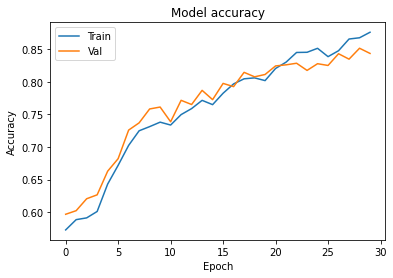

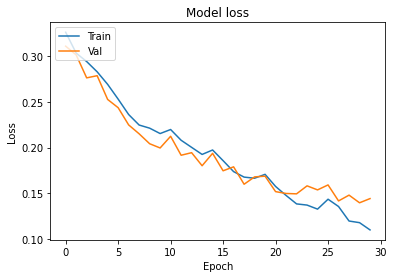

In [74]:
plot_history(model_history)

Let us visualize few of our predictions. Try a bunch of images in the test set.

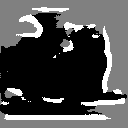

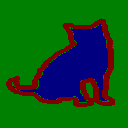

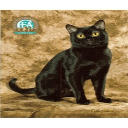

[0 1 2]


In [75]:
#val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = unet_model.predict(x_test/255.0)
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    cv2_imshow(mask*128)
    cv2_imshow(y_test[i]*128)
    cv2_imshow(x_test[i])
    print(np.unique(mask))
# Display results for validation image #10
i = 0
# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

**Exercise 2** 
Try to change few parameters in the Unet, e.g.:
- add a dropout (after maxpooling) to the downsample block;
- Use more images for training;
- Change the learning rate;
- Change the optimizer. 
Comments on how the results change. 
If you want, you can change the metrics to IoU.

##  <font color="blueviolet"> add a dropout (after maxpooling) to the downsample block:

### <font color="navy"> Below are the results without dropout layer ( first two plots ) and with dropout layer ( last two plots ):

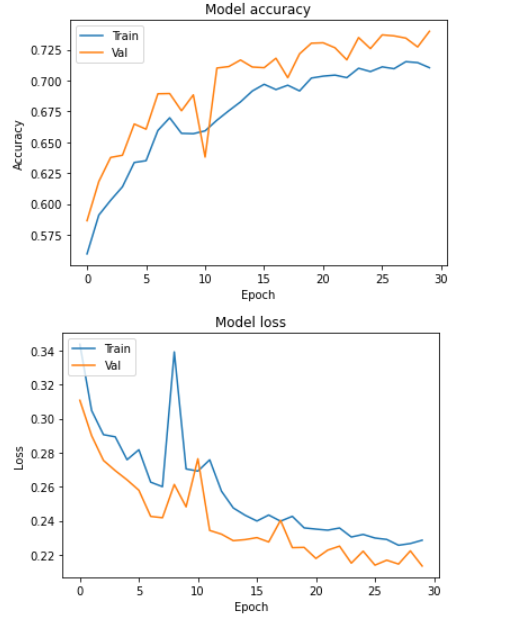

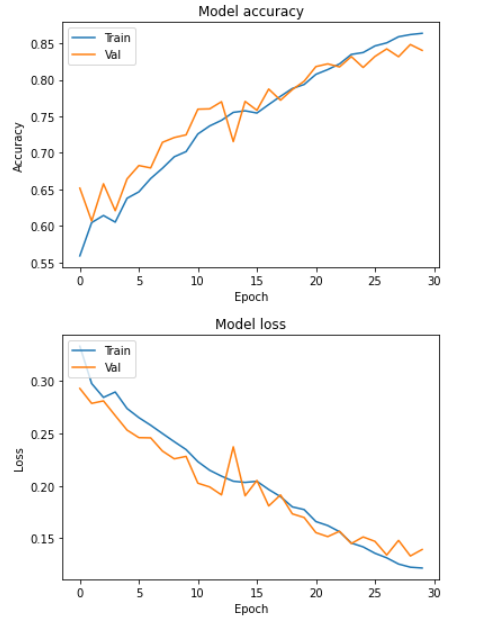

### <font color="navy"> As it can be seen when we add a drop out layer our maximum accuracy increase from nearly 72% to above 85%. On the other hand in the case of loss, we can see that the model with dropout layer, ended up in nearly 0.1 loss for both train and validation while this is double time bigger for the model without dropout layer.

##  <font color="blueviolet"> Use more images for training:

### <font color="navy"> Here I have used test size=0.3 with 500 and 600 samples for the training of the model. As it can be seen, when we increase the model of training samples, our train accuracy remain unchanged but more importantely, the test accuracy increase to a great extend. 

0.3 test.PNG

### <font color="navy"> 500 sample for training

train with 600 samples and 0.3 test rate.PNG

### <font color="navy"> 600 sample for training

##  <font color="blueviolet"> Change the optimizer. Comments on how the results change. If you want, you can change the metrics to IoU :

### <font color="navy"> Using SGD i got Train: 0.583, Test: 0.529 in the case of accuracy. while these were much higher in the case of adam optimizer ( Train: 0.868, Test:0.736). In my opinion the best optimizer for this model would be Adam which will give a good final result while the others not only do not give an acceptable final result but in each step we don't see any tangible change until the end.

**Exercise 3**
Let us try a pre-trained model, which is available in the library segmentation_models. 
- Comments on the results. 
  - Does the performances improve? 
  - Why do you think this is happening?

**Bonus exercise**
- Try to change the model with a LinkNet, and comments on the results 

### <font color="navy"> the first reason why the performance is improving using a pre-trained model is the fact that using these models model requires less training and requires less effort for building the architecture. Another point is the accuracy. Using a pre-trained model is significantly more accurate than using a custom-built network.But the next part shows that for this number of data maybe using a complecated model cannot be a good choice cause when we improve in the case of training the test part is poor and I think this caused because of overfitting.

In [78]:
from sklearn.model_selection import train_test_split 
import segmentation_models as sm
sm.set_framework('tf.keras')
BACKBONE = 'efficientnetb0'
preprocess_input = sm.get_preprocessing(BACKBONE)

#use the same training and validation generators defined before

# preprocess input
# define model
model = sm.Linknet(BACKBONE, encoder_weights='imagenet',classes=3,activation='softmax')
model.compile(
    'Adam',
    loss=sm.losses.categorical_crossentropy,
    metrics=['accuracy'],
)
model.fit(x_train,y_train,validation_data=(x_val,y_val), batch_size = 30,epochs=25,verbose=2)
_, train_acc =model.evaluate(x_train, y_train, verbose=1)
_, test_acc =model.evaluate(x_test, y_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Epoch 1/25
14/14 - 13s - loss: 0.3227 - accuracy: 0.5405 - val_loss: 0.9389 - val_accuracy: 0.6605 - 13s/epoch - 911ms/step
Epoch 2/25
14/14 - 2s - loss: 0.2078 - accuracy: 0.7812 - val_loss: 1.7796 - val_accuracy: 0.5728 - 2s/epoch - 170ms/step
Epoch 3/25
14/14 - 2s - loss: 0.1326 - accuracy: 0.8611 - val_loss: 0.8723 - val_accuracy: 0.6843 - 2s/epoch - 176ms/step
Epoch 4/25
14/14 - 2s - loss: 0.1014 - accuracy: 0.8929 - val_loss: 1.0603 - val_accuracy: 0.5985 - 2s/epoch - 175ms/step
Epoch 5/25
14/14 - 2s - loss: 0.0880 - accuracy: 0.9054 - val_loss: 0.8423 - val_accuracy: 0.6767 - 2s/epoch - 173ms/step
Epoch 6/25
14/14 - 3s - loss: 0.0789 - accuracy: 0.9127 - val_loss: 0.3474 - val_accuracy: 0.7894 - 3s/epoch - 179ms/step
Epoch 7/25
14/14 - 2s - loss: 0.0755 - accuracy: 0.9164 - val_loss: 0.3904 - val_accuracy: 0.7619 - 2s/epoch - 172ms/step
Epoch 8/25
14/14 - 2s - loss: 0.0713 - accuracy: 0.9196 - val_loss: 0.2834 - val_accuracy: 0.7934 - 2s/epoch - 173ms/step
Epoch 9/25
14/14 - 2s 